In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings
#from zipfile import ZipFile

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report

Using TensorFlow backend.


In [0]:
np.random.seed(8)

In [0]:
!pwd
%cd "drive/My Drive/CVProject"
!pwd

/content
/content/drive/My Drive/CVProject
/content/drive/My Drive/CVProject


In [0]:
class_names = os.listdir('UCMerced_LandUse/Train/')
target_dirs = {target: './UCMerced_LandUse/' + target for target in ['Train', 'Validation', 'Test']}

In [0]:
print(class_names)
print(target_dirs)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'storagetanks', 'runway', 'tenniscourt', 'sparseresidential']
{'Train': './UCMerced_LandUse/Train', 'Validation': './UCMerced_LandUse/Validation', 'Test': './UCMerced_LandUse/Test'}


In [0]:
def get_bottleneck_features(model, dataset, batch_size=64):
  print(f'Generating "{dataset}" bottleneck predictions')
  image_data_gen = ImageDataGenerator(rescale=1/255.0)
  image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                        batch_size=batch_size,
                                                        shuffle=False)
  image_count = 0
  X_batches, Y_batches = [], []
  for X, Y in image_generator:
    X_batches.append(model.predict_on_batch(X))
    Y_batches.append(Y)
    image_count += X.shape[0]
    # Must interrupt image_generator
    if image_count >= image_generator.n:
      break
  X = np.concatenate(X_batches)
  Y = np.concatenate(Y_batches)
  return X, Y

In [0]:
pretrained_model = applications.InceptionResNetV2(include_top=False, weights='imagenet')

219062272/219055592 [==============================] - 17s 0us/step


In [0]:
num_classes = len(class_names)
X, Y = dict(), dict()
for dataset in ['Train', 'Validation', 'Test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features(pretrained_model, dataset)

Generating "Train" bottleneck predictions
Found 1785 images belonging to 21 classes.
Generating "Validation" bottleneck predictions
Found 210 images belonging to 21 classes.
Generating "Test" bottleneck predictions
Found 210 images belonging to 21 classes.


In [0]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [0]:
model = build_fully_connected(input_shape=X['Train'].shape[1:], num_classes=num_classes)
adam = optimizers.Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['Train'], Y['Train'], batch_size=64, epochs=300,
                              verbose=2, validation_data=(X['Validation'], Y['Validation']))

Train on 1785 samples, validate on 210 samples
Epoch 1/300
 - 1s - loss: 2.3428 - accuracy: 0.4717 - val_loss: 0.9416 - val_accuracy: 0.6857
Epoch 2/300
 - 1s - loss: 0.7450 - accuracy: 0.7709 - val_loss: 0.5420 - val_accuracy: 0.8476
Epoch 3/300
 - 1s - loss: 0.4028 - accuracy: 0.8728 - val_loss: 0.4129 - val_accuracy: 0.8857
Epoch 4/300
 - 1s - loss: 0.3027 - accuracy: 0.9036 - val_loss: 0.4720 - val_accuracy: 0.8810
Epoch 5/300
 - 1s - loss: 0.2244 - accuracy: 0.9272 - val_loss: 0.3386 - val_accuracy: 0.8952
Epoch 6/300
 - 1s - loss: 0.1570 - accuracy: 0.9552 - val_loss: 0.3387 - val_accuracy: 0.8857
Epoch 7/300
 - 1s - loss: 0.1445 - accuracy: 0.9574 - val_loss: 0.3935 - val_accuracy: 0.8714
Epoch 8/300
 - 1s - loss: 0.1231 - accuracy: 0.9653 - val_loss: 0.2857 - val_accuracy: 0.8857
Epoch 9/300
 - 1s - loss: 0.0914 - accuracy: 0.9709 - val_loss: 0.3526 - val_accuracy: 0.8571
Epoch 10/300
 - 1s - loss: 0.0873 - accuracy: 0.9720 - val_loss: 0.3400 - val_accuracy: 0.8762
Epoch 11/300

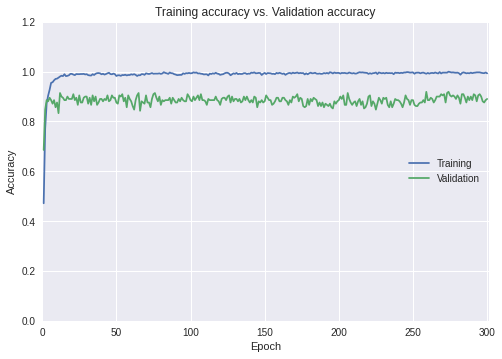

In [0]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['accuracy'])
plt.plot(x, model_fit_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

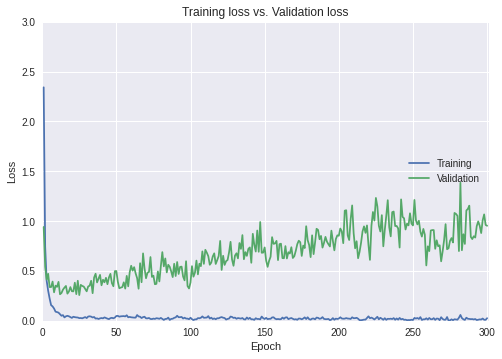

In [0]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()


In [0]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(f'Stop training at {epochs} epochs')

# Merge training and validation data
X_train = np.concatenate([X['Train'], X['Validation']])
Y_train = np.concatenate([Y['Train'], Y['Validation']])

# Randomly shuffle X and Y
shuffle_index = np.random.permutation(len(X_train))
X_train = X_train[shuffle_index]
Y_train = Y_train[shuffle_index]
model = build_fully_connected(input_shape=X_train.shape[1:], num_classes=num_classes)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X_train, Y_train, batch_size=64, epochs=epochs, verbose=0)

Stop training at 25 epochs


In [0]:
y_pred = model.predict_classes(X['Test'], verbose=0)

In [0]:
y_test = np.nonzero(Y['Test'])[1]
accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')

Model predication accuracy: 0.890

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.80      0.89        10
           2       0.89      0.80      0.84        10
           3       1.00      1.00      1.00        10
           4       0.75      0.90      0.82        10
           5       1.00      0.90      0.95        10
           6       0.75      0.30      0.43        10
           7       0.91      1.00      0.95        10
           8       0.90      0.90      0.90        10
           9       1.00      1.00      1.00        10
          10       1.00      0.90      0.95        10
          11       0.90      0.90      0.90        10
          12       0.64      0.70      0.67        10
          13       0.82      0.90      0.86        10
          14       0.91      1.00      0.95        10
          15       0.91      1.00      0.95        10
          16       1.0